<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Databehandling-Pradeep/Bioco_Databehandling_av_manglende_verdier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importering av nødvendige pakker og bibliotek

In [ ]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime
import time
import math

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from statsmodels.graphics.tsaplots import plot_acf

Importering av data

In [ ]:
# Velger første kolonne med dato og tid som index
bioco_data = pd.read_csv('/content/drive/MyDrive/MasterV24/Bioco_data/førbehandlet_bioco_data.csv',
                         header=0,
                         sep=',',
                         index_col=0)

# Formatterer index til riktig format og datatype
bioco_data.index = pd.to_datetime(bioco_data.index,
                                  format='%Y-%m-%d %H:%M:%S')

# Funksjoner

## Behandling av manglende verdier for variabler

In [ ]:
def håndter_manglende_verdier(prosessert_data,
                              diff_max=15,
                              variabler=['NIRfat']):

  for variabel in variabler:
    print(variabel)

    # Henter ut index til rader med manglende verdier for variabel
    manglende_index = prosessert_data[prosessert_data[variabel].isnull()].index

    # Lager liste for å lagre start og slutttid for serie med manglende verdier
    manglende_index_start, manglende_index_slutt = list(), list()

    # Legger til starttid for første serie med manglende verdier
    manglende_index_start.append(manglende_index[0])

    # Lagrer alle start og slutttid for serier med 1 min intervall og manglende verdier
    for i in range(1, len(manglende_index)):
      tidsdiff = manglende_index[i] - manglende_index[i-1]

      if tidsdiff.total_seconds() > 60:
        manglende_index_slutt.append(manglende_index[i-1])
        manglende_index_start.append(manglende_index[i])

    # Legger til slutttid for siste serie med manglende verdier
    manglende_index_slutt.append(manglende_index[-1])

    # Lagring av antall manglende verdier i korte intervaller
    res_manglende_korteintervall = 0

    # Lager liste for start og slutt på korte intervaller og lengre intervaller
    # med manglende verdier for variabel
    manglende_maksdiff, manglende_mindiff = list(), list()

    for i,j in zip(manglende_index_start, manglende_index_slutt):
      mangel = prosessert_data[i:j].isnull().sum()[variabel]

      # Lagrer alle start og sluttid for korte intervaller mindre enn maks tid
      if mangel <= diff_max:
        manglende_maksdiff.append((i,j))

        # Summerer antall manglende verdier i de korte intertaller
        res_manglende_korteintervall += mangel

        # Sjekker om de korte intervaller inneholder kvalitetsmålinger
        respons_mangel = prosessert_data[i:j].isnull().sum()[['Collagen',
                                                              'Mw',
                                                              'SmallMolecules',
                                                              'BrixAdjusted']]
        if mangel > min(respons_mangel.values):
          print(f"Tidsintervallet {i} til {j} har flere manglende variabel-målinger enn kvalitetsmålinger")
          print(f"{variabel} {mangel}")
          print(respons_mangel)

        # Lagrer alle start og slutttid for lengre intervaller mer enn maks tid
      else:
        manglende_mindiff.append((i,j))

    print(f"{res_manglende_korteintervall} av {prosessert_data.isnull().sum()[variabel]} {variabel} målinger som mangler er i kortere intervaller enn {diff_max} min")

    # Dropper de intervaller mer enn maks tid med manglende verdier for variabel
    for start, slutt in manglende_mindiff:
        prosessert_data = prosessert_data[(prosessert_data.index < start) | (prosessert_data.index > slutt)]

  return prosessert_data

# Analysere tidsaspekt av data

In [ ]:
def konverter_tid(sekunder):
  tid = time.gmtime(sekunder)
  dager, timer, minutter = tid[2], tid[3], tid[4]
  return dager, timer, minutter


def analyser_tidserier(bioco_rå_data, max_diff_seconds=60.0):
    # Lager lister for å lagre start- og slutttidspunkt på kontinuerlige tidserier
    tid_observasjon_start = []
    tid_observasjon_slutt = []

    # Legger til første observasjon i listen med startstider
    tid_observasjon_start.append(bioco_rå_data.index[0])

    # Går igjennom datasettet og lagrer slutt- og startstid på tidsintervaller
    # mer enn max_diff_seconds sekunder
    for i in range(1, len(bioco_rå_data.index)):
        tidsdiff = bioco_rå_data.index[i] - bioco_rå_data.index[i-1]
        if tidsdiff.total_seconds() > max_diff_seconds:
            tid_observasjon_slutt.append(bioco_rå_data.index[i-1])
            tid_observasjon_start.append(bioco_rå_data.index[i])

    # Legger til siste observasjonstid i datasettet
    tid_observasjon_slutt.append(bioco_rå_data.index[-1])

    print("Det er {} kontinuerlige observasjoner med intervall på 1 min:".format(len(tid_observasjon_slutt)))

    lengst_kontinuitet = 0
    kortest_kontinuitet = math.inf
    lengst_passiv = 0
    kortest_passiv = math.inf

    forrige_stopp = False
    forrige_korteste_passiv = False

    # Får oversikt over kontinuerlige datasett
    for start, slutt in zip(tid_observasjon_start, tid_observasjon_slutt):
        uke = start.isocalendar().week

        print("Uke {}: Tidsintervallet {} til {}"
              " er kontinuerlig tidserie".format(uke, start, slutt))

        # Beregner kontiuitet i tidseriedata
        kontinuitet = (slutt - start).total_seconds()

        if kontinuitet < kortest_kontinuitet:
            kortest_kontinuitet = kontinuitet
        if kontinuitet >= lengst_kontinuitet:
            lengst_kontinuitet = kontinuitet

        # Beregner tid mellom sist tidspunkt for datasinnsamling og nest tidspunkt
        # for datainnsamling
        if forrige_stopp:
            passiv = (start - forrige_stopp).total_seconds()
            # Ser bort i fra mangel på datainnsamling i helger og stopp mellom uke 50
            # til uke 26
            if konverter_tid(passiv)[0] - 1 < 2:
                if passiv < kortest_passiv:
                    forrige_korteste_passiv = kortest_passiv
                    kortest_passiv = passiv
                if passiv >= lengst_passiv:
                    lengst_passiv = passiv

        forrige_stopp = slutt

    print("Lengst kontinuitet: {} dager, {} timer og {} minutter".format(konverter_tid(lengst_kontinuitet)[0]-1,
                                                                         konverter_tid(lengst_kontinuitet)[1],
                                                                         konverter_tid(lengst_kontinuitet)[2]))
    print("Kortest kontinuitet: {} dager, {} timer og {} minutter".format(konverter_tid(kortest_kontinuitet)[0]-1,
                                                                          konverter_tid(kortest_kontinuitet)[1],
                                                                          konverter_tid(kortest_kontinuitet)[2]))
    print("Lengst passivitet: {} dager, {} timer og {} minutter".format(konverter_tid(lengst_passiv)[0]-1,
                                                                        konverter_tid(lengst_passiv)[1],
                                                                        konverter_tid(lengst_passiv)[2]))
    print("Forrige kortest passivitet: {} dager, {} timer og {} minutter".format(konverter_tid(forrige_korteste_passiv)[0]-1,
                                                                         konverter_tid(forrige_korteste_passiv)[1],
                                                                         konverter_tid(forrige_korteste_passiv)[2]))

In [ ]:
def konverter_tidserier(bioco_rå_data,
                        max_diff_seconds=60.0,
                        faktor=5,
                        valg='første',
                        liste_markerte=None):

    # Lager lister for å lagre start- og slutttidspunkt på kontinuerlige tidserier
    tid_observasjon_start = []
    tid_observasjon_slutt = []

    # Legger til første observasjon i listen med startstider
    tid_observasjon_start.append(bioco_rå_data.index[0])

    # Går igjennom datasettet og lagrer slutt- og startstid på tidsintervaller
    # mer enn max_diff_seconds sekunder
    for i in range(1, len(bioco_rå_data.index)):
        tidsdiff = bioco_rå_data.index[i] - bioco_rå_data.index[i-1]
        if tidsdiff.total_seconds() > max_diff_seconds:
            tid_observasjon_slutt.append(bioco_rå_data.index[i-1])
            tid_observasjon_start.append(bioco_rå_data.index[i])

    # Legger til siste observasjonstid i datasettet
    tid_observasjon_slutt.append(bioco_rå_data.index[-1])

    print("Det er {} kontinuerlige observasjoner med intervall på {} min:".format(len(tid_observasjon_slutt), max_diff_seconds/60))

    # Ny DataFrame for transformerte data
    transformerte_data = pd.DataFrame()

    # Får oversikt over kontinuerlige datasett
    for start, slutt in zip(tid_observasjon_start, tid_observasjon_slutt):
        uke = start.isocalendar().week

        print("Uke {}: Tidsintervallet {} til {} er kontinuerlig tidserie".format(uke, start, slutt))

        # Gå gjennom tidsserien i 5-minutters intervaller
        sub_data = bioco_rå_data[start:slutt]
        sub_data_resampled = []

        for i in range(0, len(sub_data), faktor):
            chunk = sub_data[i:i+faktor]

            if valg == 'første':
                resampled_point = chunk.iloc[0]
            elif valg == 'siste':
                resampled_point = chunk.iloc[-1]
            elif valg == 'markert':
              maske = chunk[liste_markerte].notna().any(axis=1)
              if maske.any():
                    resampled_point = chunk[maske].iloc[0]
              else:
                    resampled_point = chunk.iloc[-1]

            sub_data_resampled.append(resampled_point)

        transformerte_data = pd.concat([transformerte_data, pd.DataFrame(sub_data_resampled)])

    return transformerte_data

# Behandling av manglende verdier

Oversikt over antall manglende verider for per kolonne

In [ ]:
bioco_data.isnull().sum()

EnzymeType_A1         0
EnzymeType_A2         0
EnzymeType_B          0
EnzymeType_C          0
EnzymeType_D          0
EnzymeType_E          0
RawMatPercent        55
NIRfat            14187
NIRash            13976
NIRwater          13958
TT08                 45
TT20                 25
TT12                  0
Collagen          43152
Mw                42711
SmallMolecules    42711
BrixAdjusted      42711
dtype: int64

Totalt manglende verdier i forklaringsdata og Andel totalt manglende verdier i data

In [ ]:
n_observasjoner = bioco_data.shape[0]

prediktor = bioco_data.columns[:-4]
n_prediktor= len(prediktor)

print(f"Totalt manglende verdier i forklaringsdata:\
 {(bioco_data[prediktor].isnull().sum().sum())}\
 og andel totalt manglende verdier:\
  {round((bioco_data[prediktor].isnull().sum().sum())/(n_observasjoner*n_prediktor), 3)}")

Totalt manglende verdier i forklaringsdata: 42246 og andel totalt manglende verdier:  0.075


Visuell oversikt over mangel på data

<Axes: >

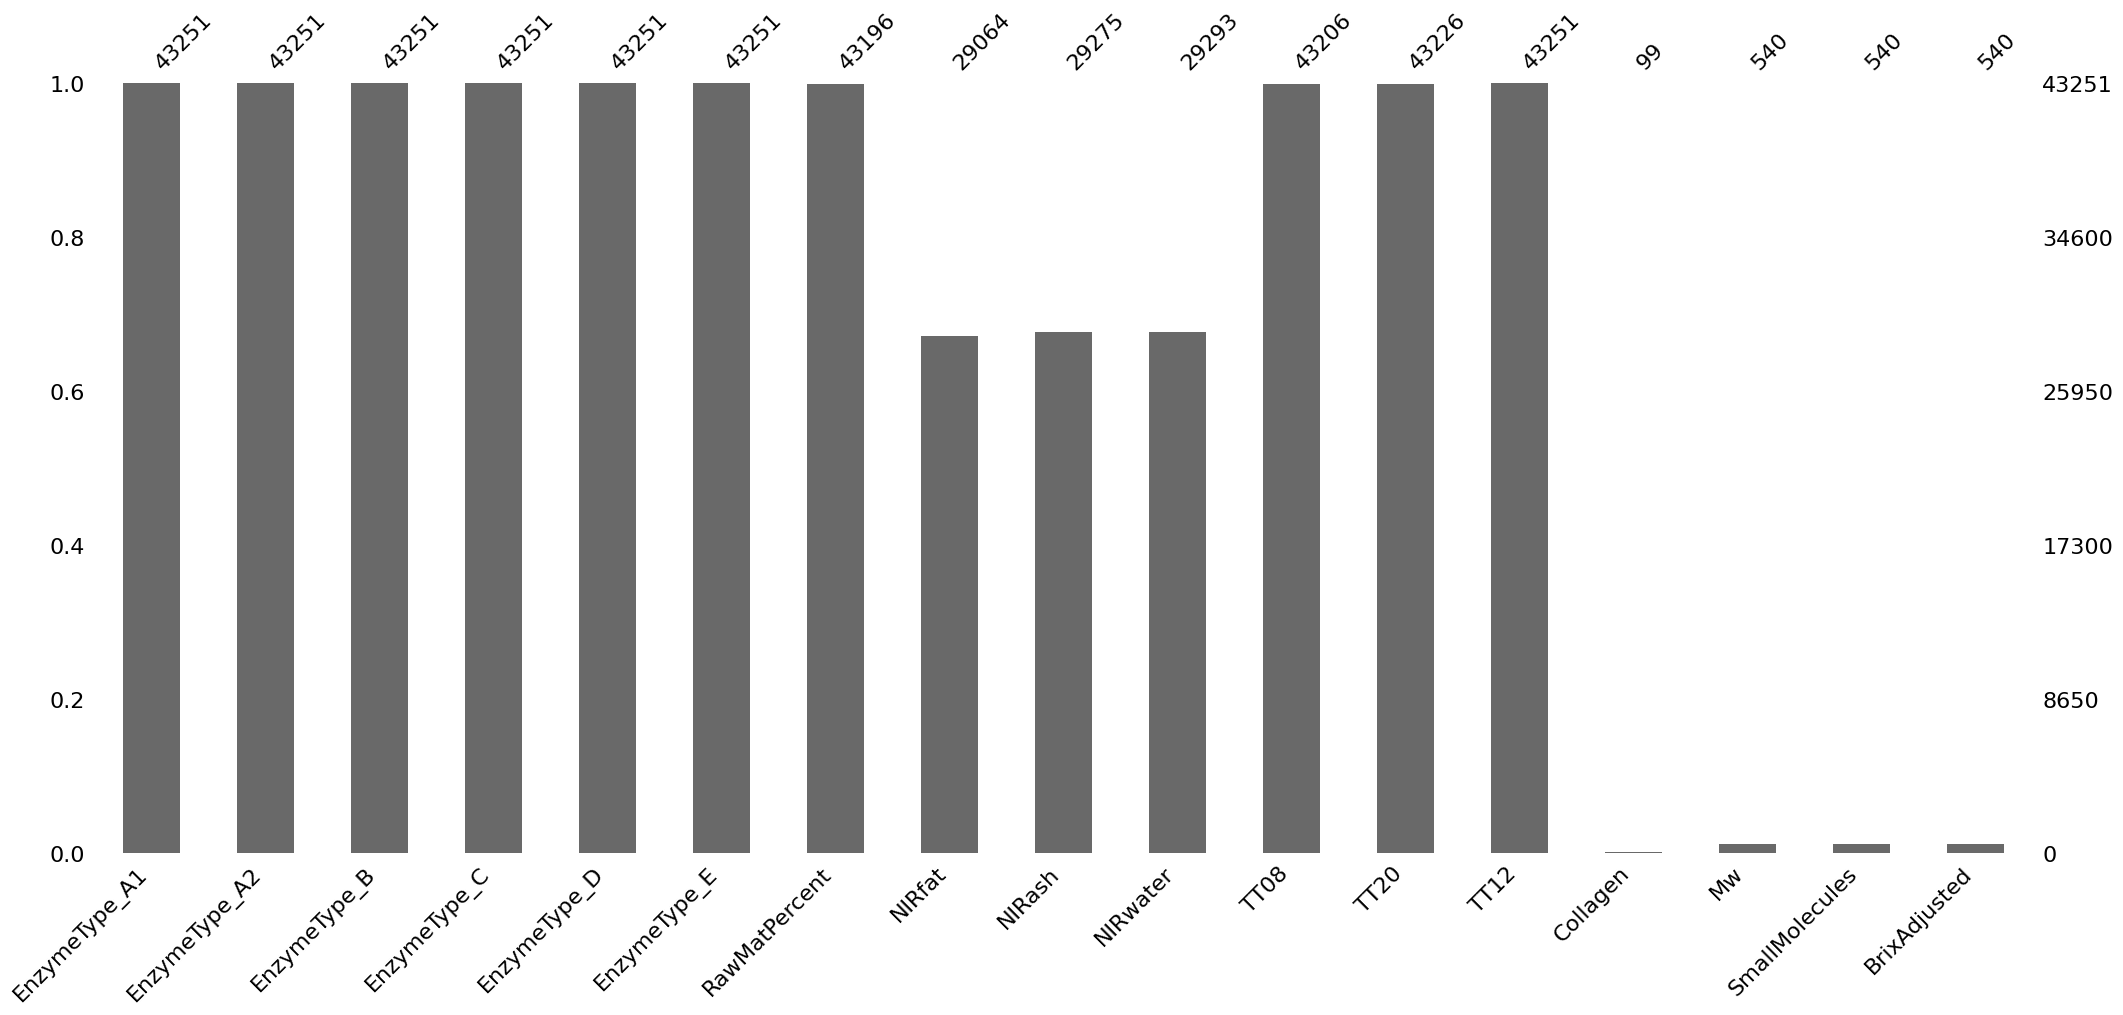

In [ ]:
msno.bar(bioco_data)

<Axes: >

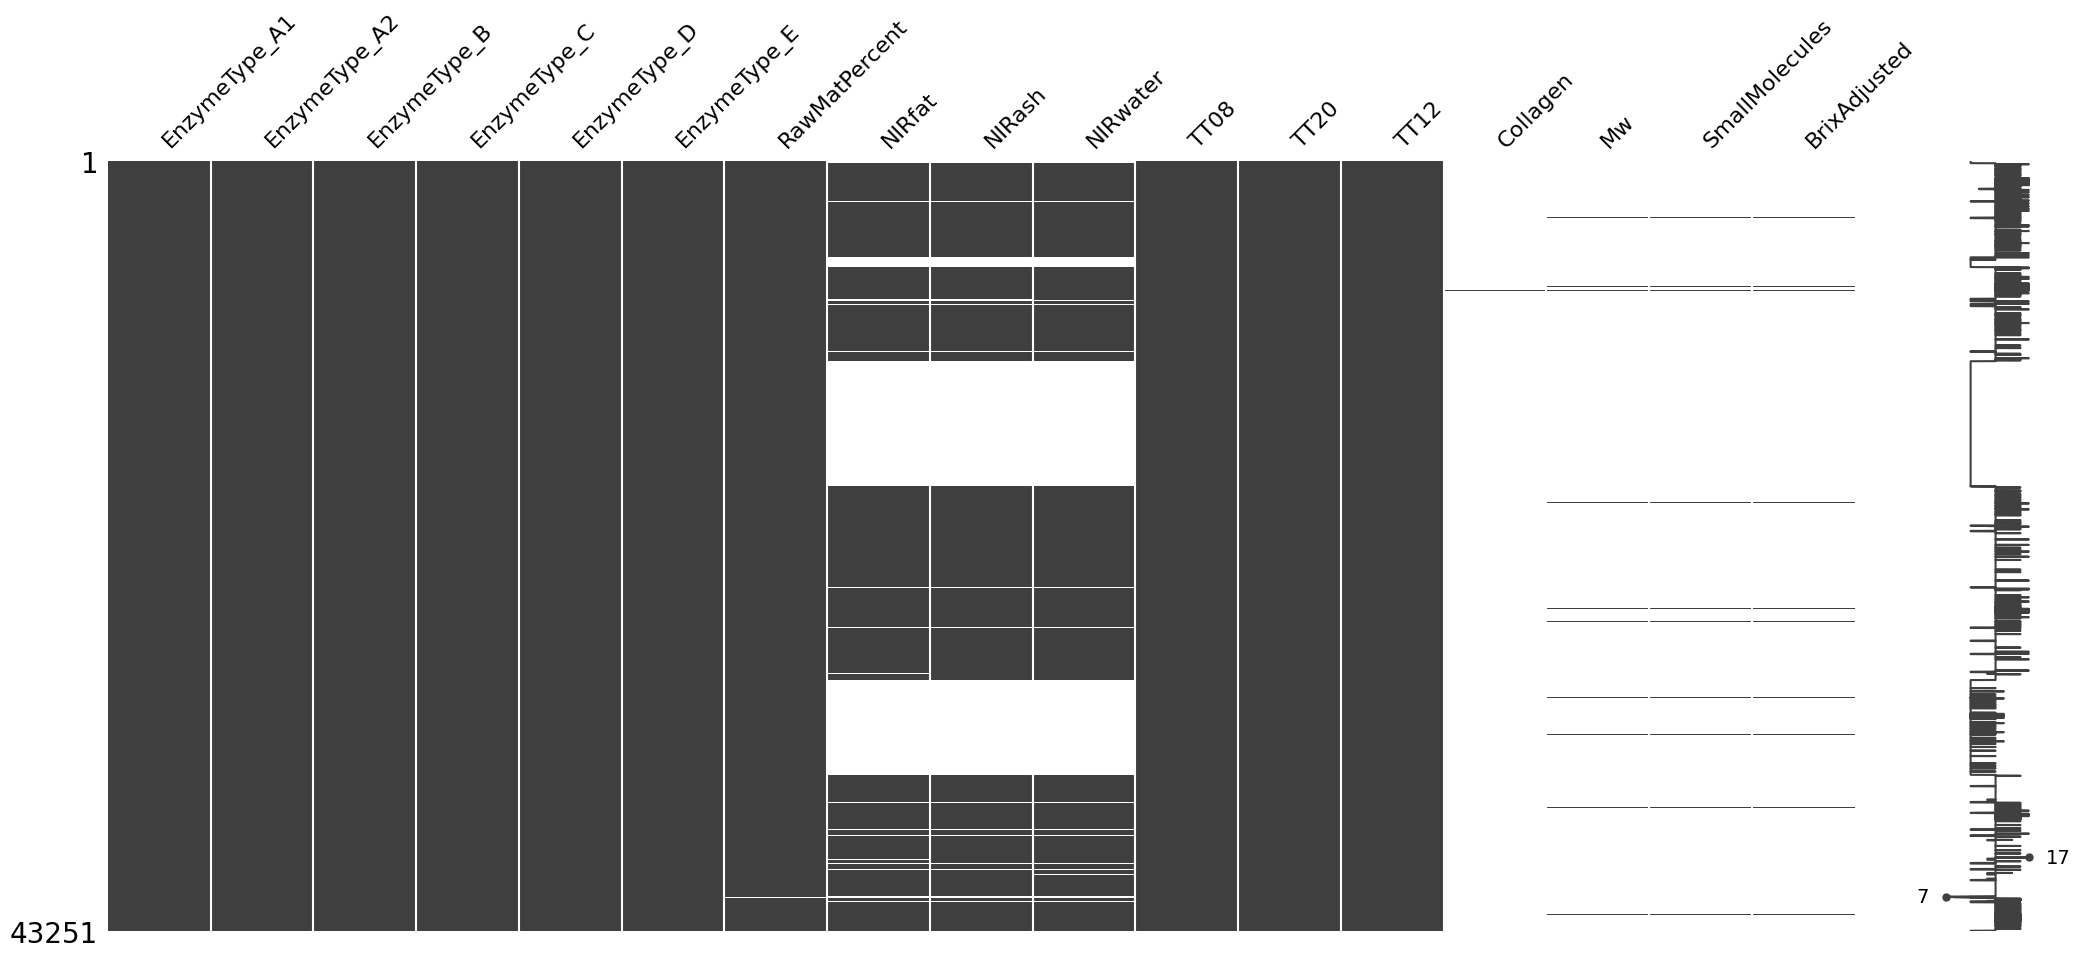

In [ ]:
msno.matrix(bioco_data)

Oversikt over og behandling av rader med manglende verdier for RawMatPercent

In [ ]:
# Henter ut index til rader med manglende verdier for "RawMatFlow"
rawmat_manglende_index = bioco_data[bioco_data['RawMatPercent'].isnull()].index
observasjons_numre = [bioco_data.index.get_loc(tid) for tid in rawmat_manglende_index.tolist()]
print(observasjons_numre)

# Sjekker hvilke andre kolonner som har manglende verdier for samme rader
print("Andre kolonner med manglende verdier sammen med 'RawMatPercent:")
print(bioco_data[rawmat_manglende_index[0]:rawmat_manglende_index[-1]].isnull().sum())

[41317, 41318, 41319, 41320, 41321, 41322, 41323, 41324, 41325, 41326, 41327, 41328, 41329, 41330, 41331, 41332, 41333, 41334, 41335, 41336, 41337, 41338, 41339, 41340, 41341, 41342, 41343, 41344, 41345, 41346, 41347, 41348, 41349, 41350, 41351, 41352, 41353, 41354, 41355, 41356, 41357, 41358, 41359, 41360, 41361, 41362, 41363, 41364, 41365, 41366, 41367, 41368, 41369, 41370, 41371]
Andre kolonner med manglende verdier sammen med 'RawMatPercent:
EnzymeType_A1      0
EnzymeType_A2      0
EnzymeType_B       0
EnzymeType_C       0
EnzymeType_D       0
EnzymeType_E       0
RawMatPercent     55
NIRfat            55
NIRash            55
NIRwater          55
TT08              45
TT20              25
TT12               0
Collagen          55
Mw                55
SmallMolecules    55
BrixAdjusted      55
dtype: int64


## Behandling av manglende verdier for NIR målinger

### ACF - plot

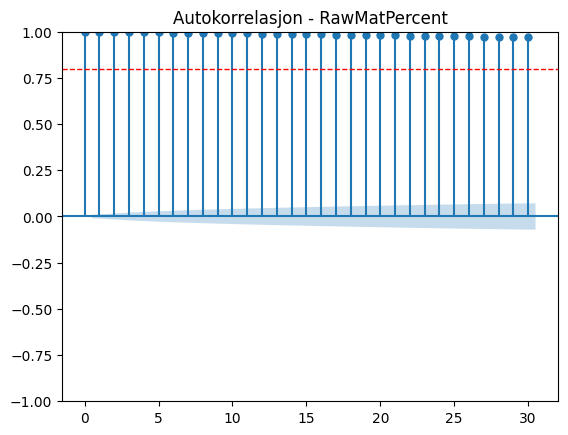

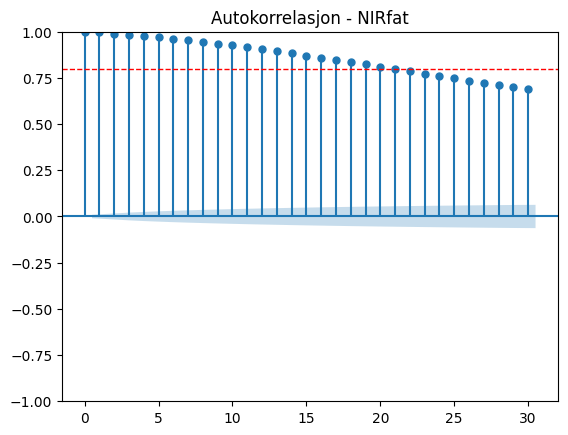

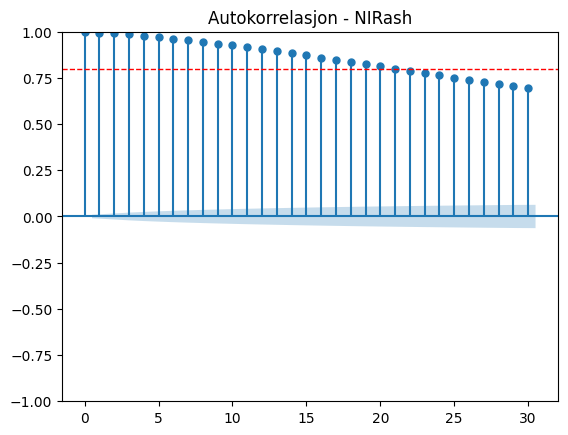

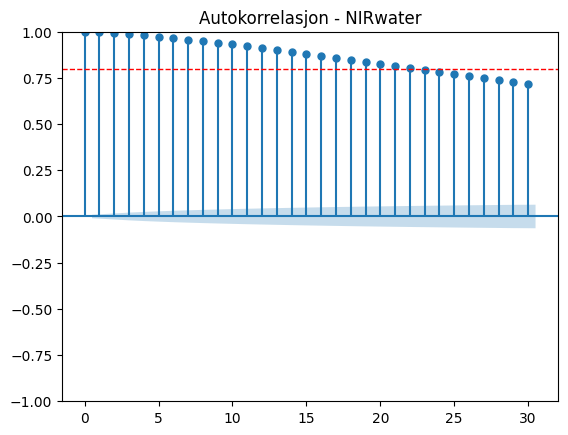

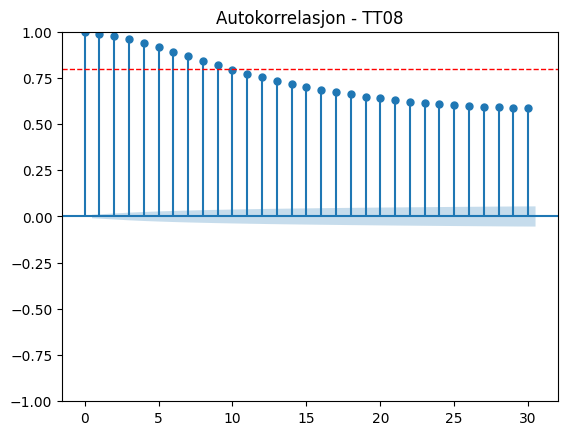

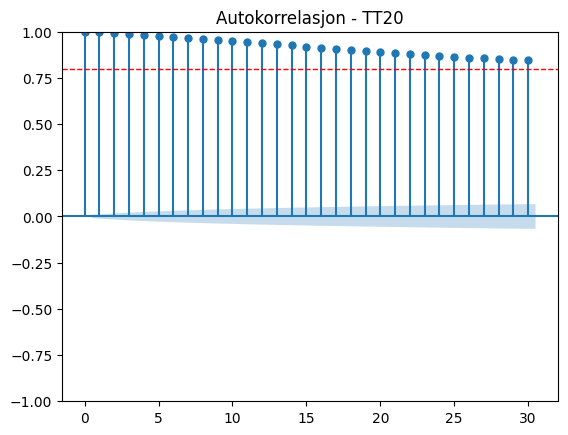

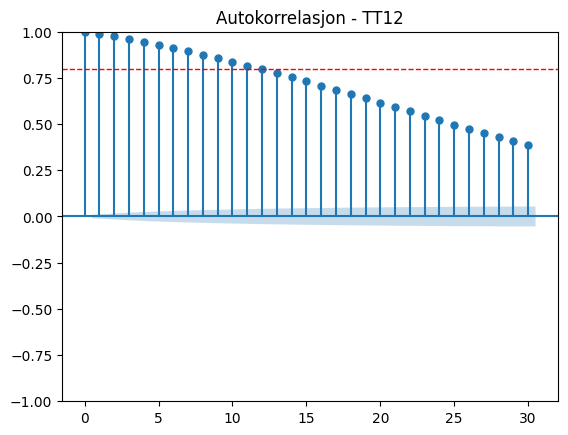

In [ ]:
prediktorer = bioco_data.columns[6:-4].to_list()

for prediktor in prediktorer:
    fig, ax = plt.subplots()
    plot_acf(bioco_data[prediktor].values.squeeze(),
             lags=30,
             missing='conservative',
             ax=ax)

    ax.axhline(y=0.8, linestyle='--', color='red', linewidth=1)
    ax.set_title('Autokorrelasjon - ' + str(prediktor))
    plt.show()

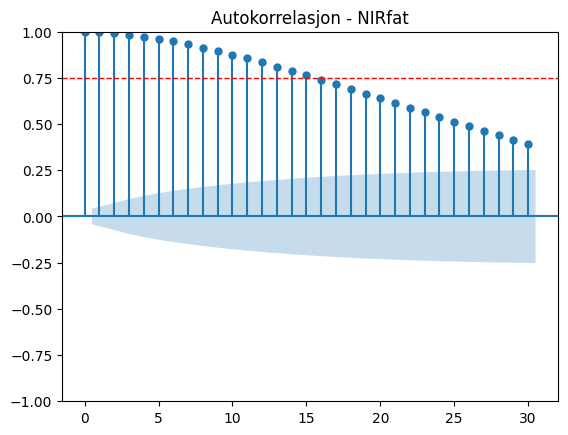

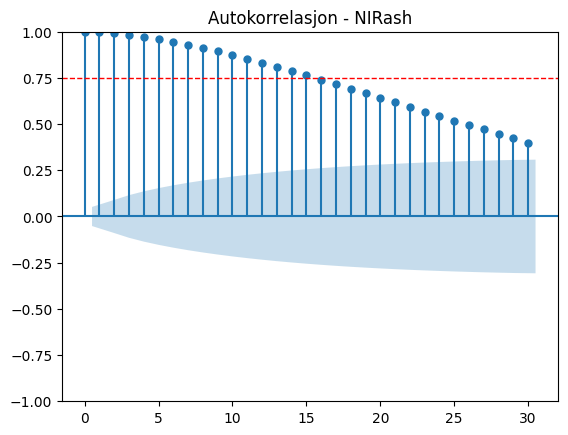

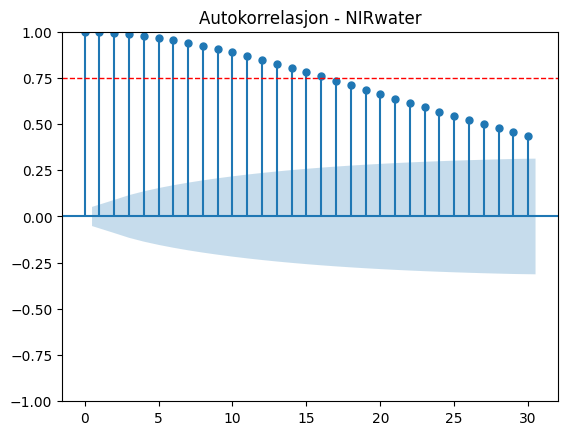

In [ ]:
nir_prediktorer = ['NIRfat', 'NIRash', 'NIRwater']

for nir in nir_prediktorer:
    nir_data = bioco_data[nir]
    første_obs = nir_data.notna().argmax()
    nir_data_først = nir_data[første_obs:]

    for i in range(1, len(nir_data_først.index)):

        tidsdiff = nir_data_først.index[i] - nir_data_først.index[i-1]
        if tidsdiff.total_seconds() > 60.0:
            nir_sekvens = nir_data_først.index[i-1]

            nir_data_sekvens = nir_data_først[:nir_sekvens]

            nir_neste_nan = nir_data_sekvens.isna().argmax()
            nir_data_sekvens = nir_data_sekvens[:nir_neste_nan]

            fig, ax = plt.subplots()
            plot_acf(nir_data_sekvens.values.squeeze(),
                     lags=30,
                     ax=ax,
                     title='Autokorrelasjon - ' + str(nir))
            ax.axhline(y=0.75, linestyle='--', color='red', linewidth=1)
            plt.show()
            break

### Dropping av bestemte intervaller med manglende verdier

Oversikt over rader med manglende verdier for NIR-målinger

In [ ]:
prosessert_data = håndter_manglende_verdier(bioco_data,
                                            diff_max=15,
                                            variabler=['RawMatPercent',
                                                       'NIRfat',
                                                       'NIRwater',
                                                       'NIRash'])

RawMatPercent
0 av 55 RawMatPercent målinger som mangler er i kortere intervaller enn 15 min
NIRfat
132 av 14132 NIRfat målinger som mangler er i kortere intervaller enn 15 min
NIRwater
144 av 204 NIRwater målinger som mangler er i kortere intervaller enn 15 min
NIRash
148 av 148 NIRash målinger som mangler er i kortere intervaller enn 15 min


# Undersøker gjenværende manglende data etter ekskludering

Kontinuerlig serier med data

In [ ]:
analyser_tidserier(prosessert_data,
                   max_diff_seconds=60.0)

Det er 54 kontinuerlige observasjoner med intervall på 1 min:
Uke 44: Tidsintervallet 2022-10-31 17:37:00 til 2022-11-01 17:27:00 er kontinuerlig tidserie
Uke 44: Tidsintervallet 2022-11-01 17:58:00 til 2022-11-02 05:19:00 er kontinuerlig tidserie
Uke 44: Tidsintervallet 2022-11-02 10:47:00 til 2022-11-03 01:58:00 er kontinuerlig tidserie
Uke 44: Tidsintervallet 2022-11-03 02:34:00 til 2022-11-04 15:07:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-07 16:40:00 til 2022-11-08 22:14:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-08 23:20:00 til 2022-11-08 23:21:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-09 02:26:00 til 2022-11-09 04:52:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-09 05:23:00 til 2022-11-09 06:37:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-09 11:28:00 til 2022-11-11 05:47:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-11 06:18:00 til 2022-11-11 14:57:00 er kontinuerlig tidserie
Uke 47: 

In [ ]:
# Filtrerer ut data for forklaringsvaribler
prediktor_data = prosessert_data.iloc[:, :-4]

# Henter ut data som skal interpoleres
prosessert_data_interpolering = prosessert_data[prediktor_data.isnull().any(axis=1)]

# Antall observasjoner med interpolert data
print(prosessert_data_interpolering.shape[0], 'observasjoner med interpolerte verdier')

# Sjekker om interpolert data inneholder markeriger
print(prosessert_data_interpolering.dropna(subset=['Mw']).shape[0], 'markerte observasjoner med interpolerte verdier')

print(prosessert_data_interpolering.dropna(subset=['Mw']))

148 observasjoner med interpolerte verdier
0 markerte observasjoner med interpolerte verdier
Empty DataFrame
Columns: [EnzymeType_A1, EnzymeType_A2, EnzymeType_B, EnzymeType_C, EnzymeType_D, EnzymeType_E, RawMatPercent, NIRfat, NIRash, NIRwater, TT08, TT20, TT12, Collagen, Mw, SmallMolecules, BrixAdjusted]
Index: []


## Interpolering av resterende manglende verdier

LOCF for behandling av manglende verdier

In [ ]:
# Datasett for prediktorer
prediktorer = prosessert_data.iloc[:, :-4].columns

# Går gjennom prediktorer og interpolerer med LOF
for prediktor in prediktorer:
  prosessert_data[prediktor] = prosessert_data[prediktor].fillna(method = 'ffill')

In [ ]:
prosessert_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   29136 non-null  int64  
 1   EnzymeType_A2   29136 non-null  int64  
 2   EnzymeType_B    29136 non-null  int64  
 3   EnzymeType_C    29136 non-null  int64  
 4   EnzymeType_D    29136 non-null  int64  
 5   EnzymeType_E    29136 non-null  int64  
 6   RawMatPercent   29136 non-null  float64
 7   NIRfat          29136 non-null  float64
 8   NIRash          29136 non-null  float64
 9   NIRwater        29136 non-null  float64
 10  TT08            29136 non-null  float64
 11  TT20            29136 non-null  float64
 12  TT12            29136 non-null  float64
 13  Collagen        89 non-null     float64
 14  Mw              460 non-null    float64
 15  SmallMolecules  460 non-null    float64
 16  BrixAdjusted    460 non-null    float64
d

Lagring av data behandlet for manglende verdier som csv

In [ ]:
prosessert_data.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/manglende_data_behandlet_bioco_data.csv')

# Informasjon om data som ble ekskludert i behandlingen

In [ ]:
# Finner hvilke rader som er unike og til felles for førbehandlet og behandlet data
samlet_data = bioco_data.merge(prosessert_data, how='left', indicator=True)

# Filtrerer ut data som ikke er tilstede i behandlet datasett
ekskludert_data = samlet_data[samlet_data['_merge'] == 'left_only'].drop(columns='_merge')

# Antall ekskluderte rader
print(ekskludert_data.shape[0], 'rader er ekskludert etter behandling av manglende verdier')

# Antall ekskluderte markerte observasjoner
print(ekskludert_data.dropna(subset=['Collagen']).shape[0],\
      'markerte observasjoner av "Collagen" er ekskludert etter behandling av manglende verdier')

print(ekskludert_data.dropna(subset=['Mw']).shape[0],\
      'markerte observasjoner av andre kvalitetsmålinger er ekskludert etter behandling av manglende verdier')

14263 rader er ekskludert etter behandling av manglende verdier
10 markerte observasjoner av "Collagen" er ekskludert etter behandling av manglende verdier
80 markerte observasjoner av andre kvalitetsmålinger er ekskludert etter behandling av manglende verdier
